## After Train Autoencoder Feature Extractor, Fine tune design for Weak, OOP, ...

In [1]:
# Intialize the tensorflow-gpu <-> physical matching

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [2]:
from load.load_data import load_opendata
from load.load_data import load_mydata

import matplotlib.pyplot as plt
%matplotlib inline
import random

In [3]:
openloader = load_opendata()
X_open, Y_open = openloader.load_data(classifier_label="OOP", dsize=(64,64), comp_ratio=4)

myloader = load_mydata()
X_my, Y_my = myloader.load_data(classifier_label="OOP", dsize=(64,64), comp_ratio=10, verbose=0)
X_my_test, Y_my_test = myloader.load_test_data(classifier_label="OOP", dsize=(64,64), comp_ratio=4, verbose=0)

print("Open data is ", len(X_open),", My Train set is ", len(Y_my),  ",  My Test set is ", len(Y_my_test))

Train opendata with Label(OOP): 100%|██████████| 22424/22424 [00:16<00:00, 1366.45it/s]
Train data Loading with OOP: 24821it [00:05, 4314.92it/s]
Test data Loading with OOP: 2000it [00:02, 984.50it/s] 

Open data is  1675 , My Train set is  989 ,  My Test set is  345


In [4]:
import numpy as np
import utils.process
from utils.process import preprocess, noise, augment, tsne_plot, display_pair, shuffler, label_dict_static, score
import importlib
importlib.reload(utils.process)

# Normalized Image
X = preprocess(X_open, shape = (64,64,3))

# Data Augmentation (5%*3=15%)
X, Y = augment(X, labels=Y_open, ratio=0.05)

# Shuffled Image
X, Y = shuffler(X, Y)

label_map, label_str = label_dict_static(classifier="OOP")
Y = np.array(list(map(lambda x: label_map[x], Y)))

Augmentation samples are 249


Before Shape is:  (1924, 12288)


No handles with labels found to put in legend.


After Shape is:  (1924, 2)


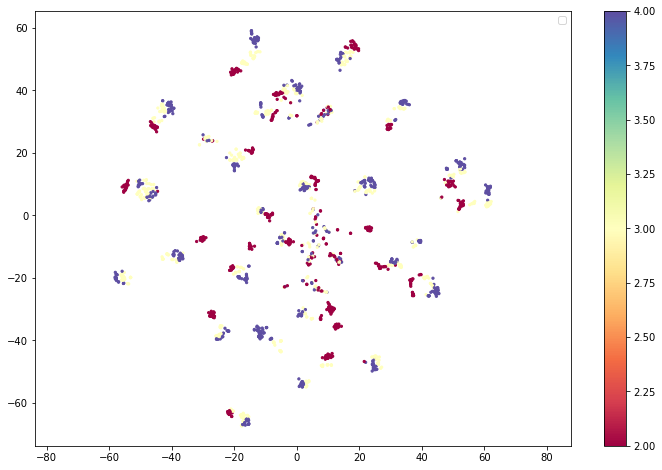

In [5]:
tsne_plot(X, Y)

In [6]:
from tensorflow.keras.models import load_model
model_load = load_model("./ckpt/"+"model_oop_autoencoder")

predictions = model_load.predict(X)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

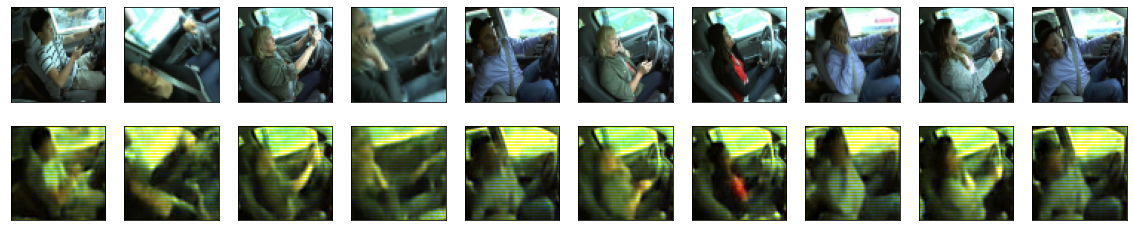

(1924, 64, 64, 3) (1924, 64, 64, 3)


In [7]:
display_pair(X, predictions)

In [9]:
model_load.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
enc_1st_conv (Conv2D)        (None, 64, 64, 64)        4864      
_________________________________________________________________
enc_1st_relu (ReLU)          (None, 64, 64, 64)        0         
_________________________________________________________________
enc_1st_maxpool (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
enc_2nd_conv (Conv2D)        (None, 32, 32, 128)       204928    
_________________________________________________________________
enc_2nd_relu (ReLU)          (None, 32, 32, 128)       0         
_________________________________________________________________
enc_2nd_maxpool (MaxPooling2 (None, 16, 16, 128)       0     

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

inputs = Input(shape=(64,64,3), name='encoder_input')
x1 = model_load.layers[0](inputs)
x2 = model_load.layers[1](x1)
x3 = model_load.layers[3](x2)
x4 = model_load.layers[4](x3)
x5 = model_load.layers[5](x4)
x6 = model_load.layers[6](x5)
x7 = model_load.layers[7](x6)
x8 = model_load.layers[8](x7)
x9 = model_load.layers[9](x8)

encoder = Model(inputs = inputs, outputs = x9, name='encoder')

In [13]:
encoder.summary()
encoder.trainable=False

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 64, 64, 3)]       0         
_________________________________________________________________
input_1 (InputLayer)         multiple                  0         
_________________________________________________________________
enc_1st_conv (Conv2D)        (None, 64, 64, 64)        4864      
_________________________________________________________________
enc_1st_maxpool (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
enc_2nd_conv (Conv2D)        (None, 32, 32, 128)       204928    
_________________________________________________________________
enc_2nd_relu (ReLU)          (None, 32, 32, 128)       0         
_________________________________________________________________
enc_2nd_maxpool (MaxPooling2 (None, 16, 16, 128)       0   

In [14]:
latent = encoder.predict(X)

In [15]:
latent.shape

(1924, 8, 8, 256)

Before Shape is:  (1924, 16384)


No handles with labels found to put in legend.


After Shape is:  (1924, 2)


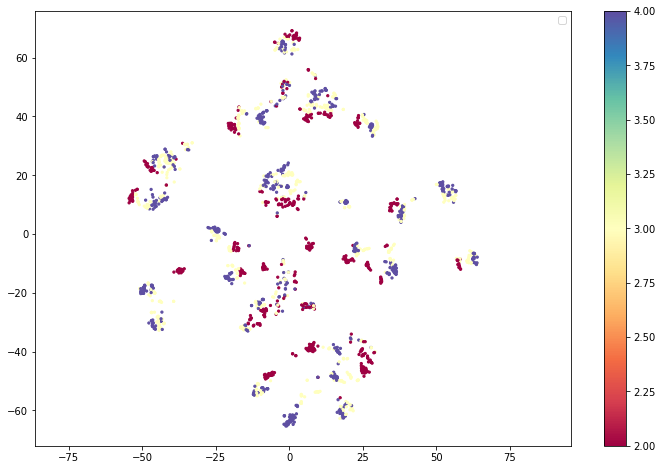

In [16]:
tsne_plot(latent, Y)